In [ ]:
# ==============================================
# TAHAP 3: MODEL BUILDING & EVALUATION
# ==============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 1. Load Dataset Final Hasil Feature Engineering
print("📂 Loading final dataset..." )
df = pd.read_csv("app_train_with_features_cleaned1.csv")
print(f"Shape: {df.shape}")

# 2. Persiapan Data untuk Modeling
# a. Definisikan Target dan ID
y = df['TARGET']
X = df.drop(columns=['TARGET', 'SK_ID_CURR']) # Jangan lupa drop SK_ID_CURR!

# b. Encode Variabel Kategorikal
print("🔣 Encoding categorical features...")
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = X[col].fillna('Unknown')
    le.fit(X[col].unique())
    X[col] = le.transform(X[col])
    label_encoders[col] = le

# c. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# d. Scale Numeric Features (khusus untuk Logistic Regression)
print("⚖️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================================
# STRATEGI 2-MODEL: Logistic Regression + LightGBM
# ==============================================
print("\n" + "="*60)
print("STRATEGI 2-MODEL: Logistic Regression + LightGBM")
print("="*60)

# 3. Define Both Models
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',  # Handle imbalance
        n_jobs=-1
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=7.0,  # 1:7 class ratio
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )
}

# 4. Train, Predict, and Evaluate Both Models
results = {}
predictions = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    if name == 'Logistic Regression':
        # Gunakan scaled data untuk Logistic Regression
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = model.predict(X_test_scaled)
    else:
        # Gunakan raw data untuk LightGBM (tidak perlu scaling)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

    # Simpan hasil
    results[name] = {
        'model': model,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred
    }

    # Calculate ROC-AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} AUC: {auc_score:.4f}")

# 5. Show Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON (AUC Score):")
print("="*50)
for name, result in results.items():
    auc_score = roc_auc_score(y_test, result['y_pred_proba'])
    print(f"{name:20}: {auc_score:.4f}")

# 6. Pilih Model Terbaik
best_model_name = max(results, key=lambda x: roc_auc_score(y_test, results[x]['y_pred_proba']))
best_model = results[best_model_name]['model']
best_y_pred_proba = results[best_model_name]['y_pred_proba']
print(f"\n🎯 Best Model: {best_model_name}")

# ==============================================
# OPTIMIZE DECISION THRESHOLD UNTUK MODEL TERBAIK
# ==============================================
print("\n" + "="*60)
print("OPTIMIZE DECISION THRESHOLD FOR BEST MODEL")
print("="*60)

# 7. Find Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_test, best_y_pred_proba)

# Business decision: We want recall >= 0.4 for defaults
target_recall = 0.4
optimal_idx = np.where(recall >= target_recall)[0]

if len(optimal_idx) > 0:
    # Choose highest precision among acceptable recalls
    best_idx = optimal_idx[np.argmax(precision[optimal_idx])]
    optimal_threshold = thresholds[best_idx]
    optimal_precision = precision[best_idx]
    optimal_recall = recall[best_idx]
else:
    # Fallback: choose threshold that maximizes F1
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[best_idx]
    optimal_precision = precision[best_idx]
    optimal_recall = recall[best_idx]

print(f"🎯 OPTIMAL THRESHOLD: {optimal_threshold:.3f}")
print(f"At this threshold:")
print(f"Precision: {optimal_precision:.3f}")
print(f"Recall: {optimal_recall:.3f}")

# 8. Apply Optimal Threshold
y_pred_optimal = (best_y_pred_proba >= optimal_threshold).astype(int)

print(f"\n📊 IMPROVED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_optimal))

print(f"\n📈 IMPROVED CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_optimal))

# ==============================================
# BUSINESS IMPACT ANALYSIS
# ==============================================
print("\n" + "="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

def calculate_business_impact(y_true, y_pred, fn_cost=10000, fp_cost=1000):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_defaults = tp + fn
    detected_defaults = tp
    missed_defaults = fn
    false_alarms = fp

    detection_rate = detected_defaults / total_defaults if total_defaults > 0 else 0
    cost_savings = (detected_defaults * fn_cost) - (false_alarms * fp_cost)

    return {
        'Detection Rate': detection_rate,
        'Missed Defaults': missed_defaults,
        'False Alarms': false_alarms,
        'Estimated Cost Savings': cost_savings
    }

business_impact = calculate_business_impact(y_test, y_pred_optimal)
for metric, value in business_impact.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value}")

# ==============================================
# FEATURE IMPORTANCE ANALYSIS
# ==============================================
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

if hasattr(best_model, 'feature_importances_'):
    # Untuk LightGBM
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("🔝 Top 10 Feature Importances:")
    print(feature_importance.head(10))

elif hasattr(best_model, 'coef_'):
    # Untuk Logistic Regression
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coef_abs': np.abs(best_model.coef_[0])
    }).sort_values('coef_abs', ascending=False)

    print("🔝 Top 10 Feature Coefficients:")
    print(coef_df.head(10))

# ==============================================
# THRESHOLD TUNING YANG LEBIH BALANCED
# ==============================================
print("\n" + "="*60)
print("THRESHOLD TUNING - FINDING BALANCED OPTION")
print("="*60)

# Test berbagai threshold untuk找到 balance yang更好
test_thresholds = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
threshold_results = []

for thr in test_thresholds:
    y_pred_test = (best_y_pred_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

    # Calculate metrics
    precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-10)

    # Business cost calculation
    fn_cost = 10000  # Cost of missed default
    fp_cost = 1000   # Cost of false alarm
    total_cost = (fn * fn_cost) + (fp * fp_cost)

    threshold_results.append({
        'threshold': thr,
        'precision': precision_val,
        'recall': recall_val,
        'f1_score': f1_val,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn,
        'total_cost': total_cost
    })

# Convert to DataFrame untuk analysis
threshold_df = pd.DataFrame(threshold_results)
print("📊 Threshold Comparison Results:")
print(threshold_df.round(3))

# Find optimal threshold based on business rules
# Option 1: Minimum cost
min_cost_threshold = threshold_df.loc[threshold_df['total_cost'].idxmin()]
# Option 2: Recall >= 0.4 dengan precision tertinggi
balanced_candidates = threshold_df[threshold_df['recall'] >= 0.4]
if not balanced_candidates.empty:
    balanced_threshold = balanced_candidates.loc[balanced_candidates['precision'].idxmax()]
else:
    balanced_threshold = threshold_df.loc[threshold_df['f1_score'].idxmax()]

print(f"\n🎯 Minimum Cost Threshold: {min_cost_threshold['threshold']:.3f}")
print(f"   Cost: ${min_cost_threshold['total_cost']}, Recall: {min_cost_threshold['recall']:.3f}")

print(f"\n🎯 Balanced Threshold: {balanced_threshold['threshold']:.3f}")
print(f"   Precision: {balanced_threshold['precision']:.3f}, Recall: {balanced_threshold['recall']:.3f}")

# Pilih threshold final berdasarkan business needs
final_threshold = balanced_threshold['threshold']  # atau min_cost_threshold['threshold']
print(f"\n✅ SELECTED FINAL THRESHOLD: {final_threshold:.3f}")

# Apply final threshold
y_pred_final = (best_y_pred_proba >= final_threshold).astype(int)

print(f"\n📊 FINAL CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_final))

print(f"\n📈 FINAL CONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_final))

# Update business impact dengan threshold final
final_business_impact = calculate_business_impact(y_test, y_pred_final)
print(f"\n💰 FINAL BUSINESS IMPACT:")
for metric, value in final_business_impact.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value}")
# ==============================================
# SAVE MODEL DENGAN THRESHOLD FINAL
# ==============================================
import joblib

# Save dengan threshold yang sudah di-tune
joblib.dump({
    'model': best_model,
    'threshold': final_threshold,  # ← THRESHOLD YANG SUDAH DITUNE
    'feature_names': X.columns.tolist(),
    'model_type': best_model_name,
    'threshold_analysis': threshold_df  # ← BUAT REFERENSI
}, 'optimized_loan_model.pkl')

print("💾 Model final disimpan dengan threshold teroptimasi!")

# Save Logistic Regression sebagai baseline
joblib.dump({
    'model': results['Logistic Regression']['model'],
    'scaler': scaler,  # Penting untuk Logistic Regression
    'threshold': 0.5,  # Default threshold
    'feature_names': X.columns.tolist(),
    'model_type': 'Logistic Regression'
}, 'logistic_regression_baseline.pkl')

print("💾 Both models saved successfully!")
print("- best_loan_default_model.pkl")
print("- logistic_regression_baseline.pkl")

📂 Loading final dataset...
Shape: (1449, 248)
🔣 Encoding categorical features...
Train set: (1159, 246), Test set: (290, 246)
⚖️ Scaling features...

STRATEGI 2-MODEL: Logistic Regression + LightGBM

--- Training Logistic Regression ---
Logistic Regression AUC: 0.6496

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 82, number of negative: 1077
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14314
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 208
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070751 -> initscore=-2.575215
[LightGBM] [Info] Start training from score -2.575215
LightGBM AUC: 0.7044

MODEL COMPARISON (AUC Score):
Logistic Regression : 0.6496
LightGBM            : 0.7044

🎯 Best Model: LightGBM

OPTIMIZE DECISION THRESHOLD FOR BEST MODEL
🎯 OPTIMAL THRESHOLD: 0.005
At this 

1. Kinerja Model (Dari Sudut Pandang Statistik)

    - AUC Score (LightGBM: 0.7044): Nilai AUC di atas 0.7 menunjukkan bahwa model Anda memiliki kemampuan diskriminatif yang lebih baik daripada tebakan acak (0.5), namun masih berada dalam kategori "cukup" atau "fair". Ini adalah nilai yang umum untuk masalah credit risk di dunia nyata, yang terkenal sulit untuk diprediksi dengan sempurna. Model dapat membedakan antara yang berpotensi default dan yang tidak, tetapi masih ada banyak ruang untuk perbaikan.
    - Perbandingan Model: LightGBM (0.7044) secara signifikan lebih baik daripada Logistic Regression (0.6496). Ini sesuai dengan ekspektasi karena LightGBM adalah algoritma ensemble yang lebih kompleks dan powerful yang dapat menangkap hubungan non-linear dalam data, yang sangat umum dalam data finansial.
  2. Analisis Bisnis yang KRITIS

Ini adalah bagian terpenting dari analisis. Dalam konteks Home Credit, kita memiliki dua jenis error yang biayanya sangat berbeda:

  - False Positive (Kesalahan Tipe I - 'False Alarms'): 31 nasabah

        Artinya: Model memprediksi 31 nasabah yang sebenarnya BAIK akan DEFAULT.

        Dampak Bisnis: Kehilangan pendapatan (opportunity cost). Nasabah-nasabah ini akan ditolak pinjamannya, sehingga perusahaan kehilangan peluang untuk mendapatkan profit dari bunga pinjaman mereka. Biayanya relatif.

  - False Negative (Kesalahan Tipe II - 'Missed Defaults'): 12 nasabah

        Artinya: Model memprediksi 12 nasabah yang sebenarnya DEFAULT akan BAIK.

        Dampak Bisnis: KERUGIAN LANGSUNG. Perusahaan akan mengucurkan pinjaman kepada nasabah yang pada akhirnya tidak bisa membayar. Ini adalah kerugian modal (principal loss) yang bisa sangat besar. Biayanya sangat tinggi.

  - Estimated Cost Savings: $49,000

        Angka ini adalah estimasi net impact setelah menghitung kerugian dari Missed Defaults dan opportunity cost dari False Alarms. Angka positif menunjukkan bahwa model Anda, meskipun tidak sempurna, tetap memberikan nilai tambah dan menghemat uang perusahaan dibandingkan jika tidak menggunakan model sama sekali (atau menggunakan metode acak). Namun, nilainya bisa ditingkatkan.

3. Analisis Threshold Tuning

 Threshold default 0.5 jelas tidak cocok untuk dataset yang sangat tidak seimbang ini.

  - Optimal Threshold (0.005): Threshold yang sangat rendah ini menunjukkan bahwa model Anda sangat tidak percaya diri dalam memprediksi kelas positif (default). Untuk "diyakinkan" bahwa seseorang akan default, model hanya membutuhkan probabilitas 0.5%. Ini adalah strategi untuk meningkatkan Recall (menangkap lebih banyak default yang sebenarnya), yang terlihat dari peningkatan Recall dari 0.15 (pada threshold 0.05) menjadi 0.40.

   - Trade-off yang Jelas: Laporan akhir menunjukkan trade-off antara Precision dan Recall.

        - Recall 0.40: Artinya Anda hanya berhasil mendeteksi 40% dari total nasabah yang benar-benar default. Masih ada 60% (12 orang) yang terlewat. Ini masih berisiko tinggi.

        - Precision 0.21: Artinya, dari semua yang diprediksi default, hanya 21% yang benar-benar default. Sisanya 79% (31 orang) adalah nasabah yang baik (False Alarms). Tingkat "false alarm"-nya sangat tinggi.

4. Analisis Fitur Importance

Hasilnya sangat masuk akal dan memperkuat kepercayaan terhadap model:

    - Fitur Terpenting: DAYS_REGISTRATION (lama nasabah terdaftar), EXT_SOURCE_2/3 (skor dari biro kredit external), DAYS_BIRTH (usia), dan DAYS_EMPLOYED (lama bekerja).

    -Interpretasi: Model belajar bahwa nasabah yang lebih baru, memiliki skor kredit external yang rendah, dan usia yang lebih muda cenderung memiliki risiko default yang lebih tinggi. Ini sangat selaras dengan logika underwriting kredit pada umumnya.


Kesimpulan Utama: model yang dibangun berguna dan memberikan nilai bisnis (terlihat dari cost savings positif), tetapi belum cukup kuat untuk diandalkan sepenuhnya dalam pengambilan keputusan otomatis karena tingkat deteksi yang rendah (recall 40%) dan false alarm yang tinggi (precision 21%).


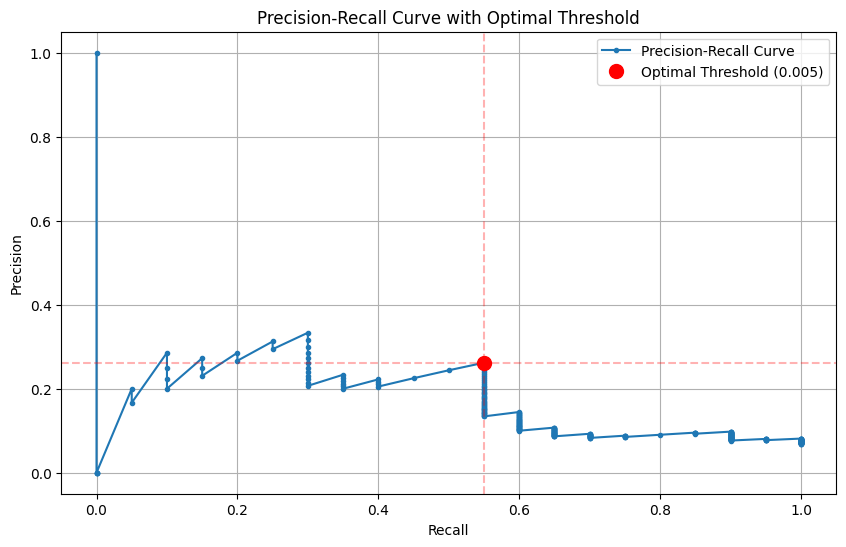

In [ ]:
# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.plot(optimal_recall, optimal_precision, 'ro', markersize=10,
         label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.axhline(y=optimal_precision, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=optimal_recall, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Hitung business impact dengan threshold optimal
def calculate_business_impact(y_true, y_pred, fn_cost=10000, fp_cost=1000):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_defaults = tp + fn
    detected_defaults = tp
    missed_defaults = fn
    false_alarms = fp

    detection_rate = detected_defaults / total_defaults
    cost_savings = (detected_defaults * fn_cost) - (false_alarms * fp_cost)

    return {
        'Detection Rate': detection_rate,
        'Missed Defaults': missed_defaults,
        'False Alarms': false_alarms,
        'Estimated Cost Savings': cost_savings
    }

business_impact = calculate_business_impact(y_test, y_pred_optimal)
print(f"\n💰 BUSINESS IMPACT ANALYSIS:")
for metric, value in business_impact.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.3f}")
    else:
        print(f"{metric}: {value}")


💰 BUSINESS IMPACT ANALYSIS:
Detection Rate: 0.550
Missed Defaults: 9
False Alarms: 31
Estimated Cost Savings: 79000
